# Association between patient features and thrombolysis use

## Aims

Replicate SAMueL-1 analysis [available to view here.](https://samuel-book.github.io/samuel-1/descriptive_stats/04_thrombolysis_general.html)

(1) Describes thrombolysis use (for all arrivals, and those arriving with 4 hours of known stroke onset) according to various patient features. Note: The association of particular features with thrombolysis use does not imply that these relationships are causal.

(2) Examines reasons why thrombolysis was not given, with a little extra about frequency of multiple reasons.

## Set up

In [1]:
# Import packages and functions
from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# Set max rows when display dataframe
pd.set_option('display.max_rows', 100)

# Linting
%load_ext pycodestyle_magic
%pycodestyle_on

In [2]:
# Set paths and filenames
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and files.'''

    data_path = './../output/'
    data_filename = 'reformatted_data.csv'
    admission_only_filename = 'reformatted_data_admissions_only.csv'


paths = Paths()

In [3]:
# Load data
data = pd.read_csv(os.path.join(paths.data_path,
                                paths.data_filename))
data_full = pd.read_csv(os.path.join(paths.data_path,
                                     paths.admission_only_filename))

## Thrombolysis use by different variables

In [4]:
def plot_ivt_differences(plot_type, column, label):
    '''
    Finds the proportion of individuals who received thrombolysis by the
    chosen characteristic, and creates a plot to summarise that
    plot_type = string, either line or bar
    column = string, column of interest
    label = string, describes the column and used on plot
    '''
    # Proportion of individuals receiving thrombolysis by characteristic
    all = 'All arrivals'
    four = 'Arrive within 4 hours\nof known stroke onset'
    ivt_group = pd.concat([
        data_full.groupby(column)['thrombolysis'].mean().rename(all),
        data.groupby(column)['thrombolysis'].mean().rename(four)],
        axis=1)*100

    # Plot those proportions
    fig, ax = plt.subplots(figsize=(5, 5))
    if plot_type == 'line':
        ax.plot(ivt_group, marker='o')
        ax.legend(ax.get_lines(), ivt_group.columns, loc='best',
                  title='Patients', ncol=1)
        ax.set_xlabel(label)
        ax.set_ylabel('Thrombolysis use (%)')
        ax.grid()
    elif plot_type == 'bar':
        ivt_group.plot(kind='bar', ax=ax)
        ax.legend(ivt_group.columns, loc='best',
                  title='Patients', ncol=1)
        ax.set_xlabel(label)
        ax.set_ylabel('Thrombolysis use (%)')
    plt.show()

**Prior disability:** The higher the level of disability before stroke (according to modified Rankin Scale, mRS), the lower the use of thrombolysis.

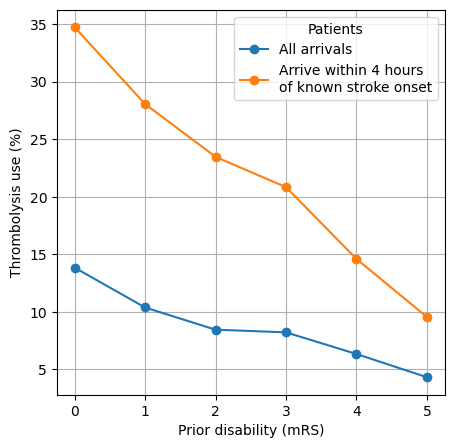

In [5]:
plot_ivt_differences('line', 'prior_disability', 'Prior disability (mRS)')

**Stroke severity:** Thrombolysis use is very low at extreme NIHSS scores. Based on threshold of 11, a higher proportion of patients receive thrombolysis for scores of 11 or more (than for scores of 10 or less).

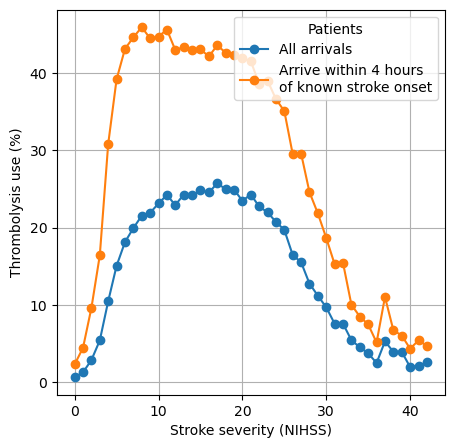

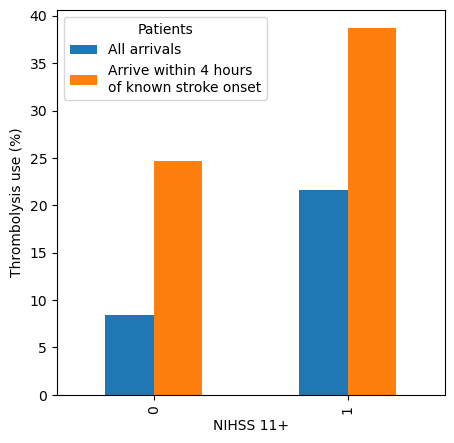

In [6]:
# Overall relationship
plot_ivt_differences('line', 'stroke_severity', 'Stroke severity (NIHSS)')

# By cut-off of NIHSS score 11 or more
data_full['nihss_11_plus'] = np.where(data_full['stroke_severity'] >= 11, 1, 0)
data['nihss_11_plus'] = np.where(data['stroke_severity'] >= 11, 1, 0)
plot_ivt_differences('bar', 'nihss_11_plus', 'NIHSS 11+')

**Gender:** A slightly higher proportion of males receive thrombolysis than females.

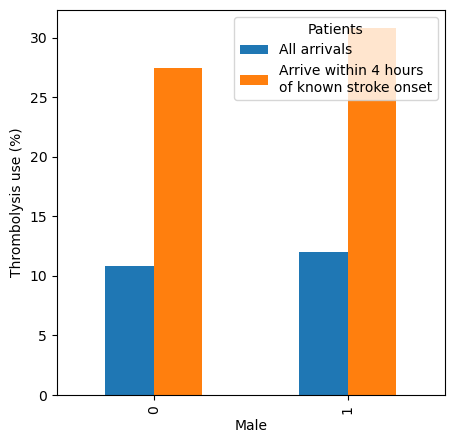

In [7]:
plot_ivt_differences('bar', 'male', 'Male')

**Ethnicity:** Not requested for SAMueL-2 (as didn't see an effect in SAMueL-1, except for slightly shorter arrival times, and as requesting more variables in SAMueL-2, so important to remove those not needed/reduce identifiability)

**Age:** Thrombolysis use declines with age.

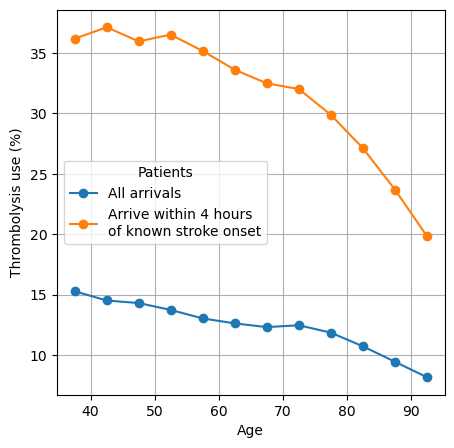

In [8]:
plot_ivt_differences('line', 'age', 'Age')

**Knowledge of time of onset:** Fairly equally split between "not known", "best estimate" and "precise estimate". Highest thrombolysis rates in patients with precise estimate, lower in those with best estimate, very few in those with unknown time of onset.

precise          0.336103
best_estimate    0.334036
unknown          0.329861
Name: onset_type, dtype: float64

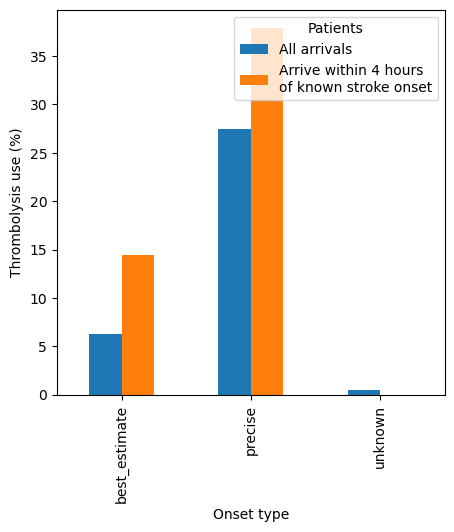

In [9]:
# Add column with three onset type categories
data_full['onset_type'] = np.where(
    data_full['precise_onset_known'] == 1, 'precise',
    np.where((data_full['precise_onset_known'] == 0) &
             (data_full['onset_known'] == 1), 'best_estimate', 'unknown'))
data['onset_type'] = np.where(
    data['precise_onset_known'] == 1, 'precise',
    np.where((data['precise_onset_known'] == 0) &
             (data['onset_known'] == 1), 'best_estimate', 'unknown'))

# Find proportion of each category in full data
display(data_full['onset_type'].value_counts(normalize=True))

# Find proportion receiving thrombolysis
plot_ivt_differences('bar', 'onset_type', 'Onset type')

**Arrive by ambulance:** Higher thrombolysis rates in patients arriving by ambulance.

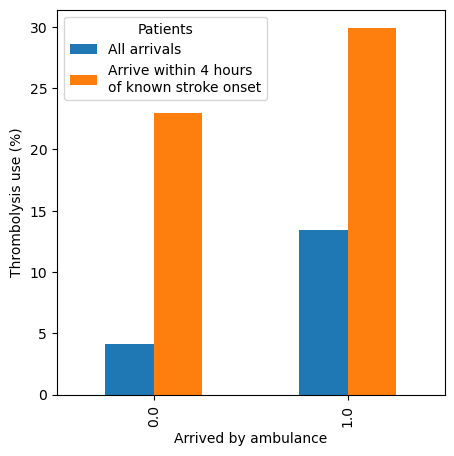

In [10]:
plot_ivt_differences('bar', 'arrive_by_ambulance', 'Arrived by ambulance')

**Presence of comorbidities:** This can also associate with thrombolysis use. For example, much lower rate in patients on anti-coagulants or with atrial fibrillation. Unlike SAMueL-1, those on anti-platelets also have lower thrombolysis rate (difference: SAMueL-1 ignored "no but").

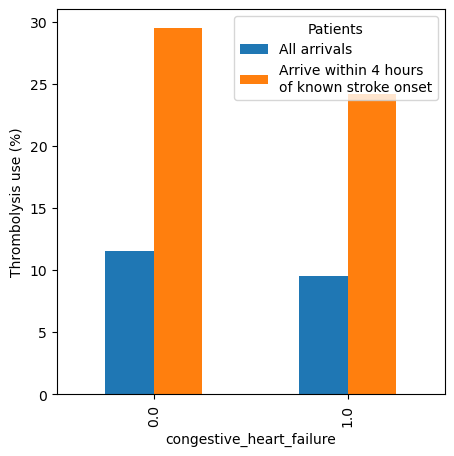

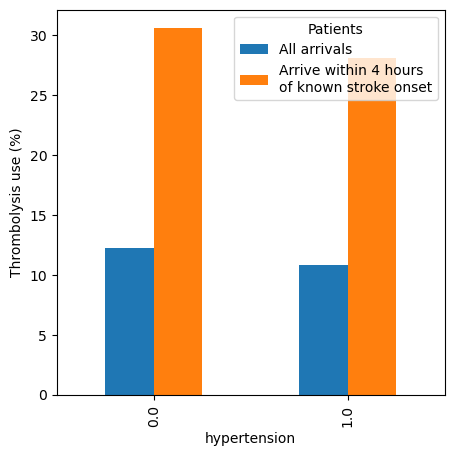

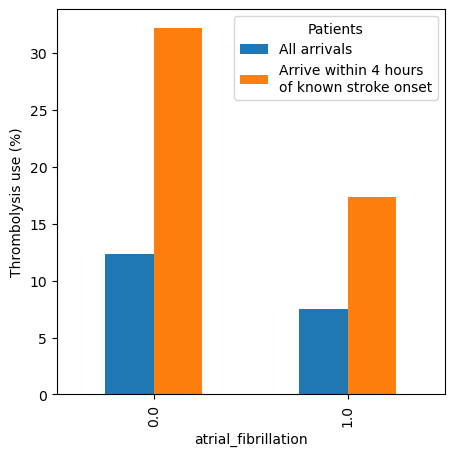

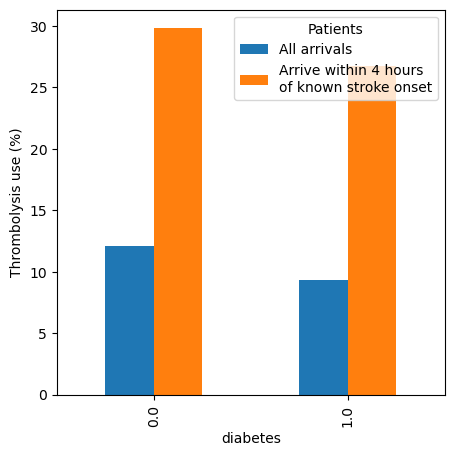

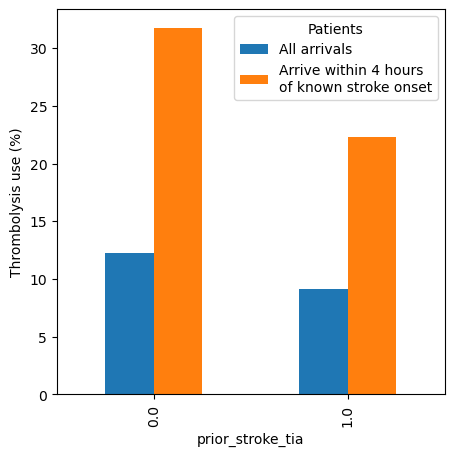

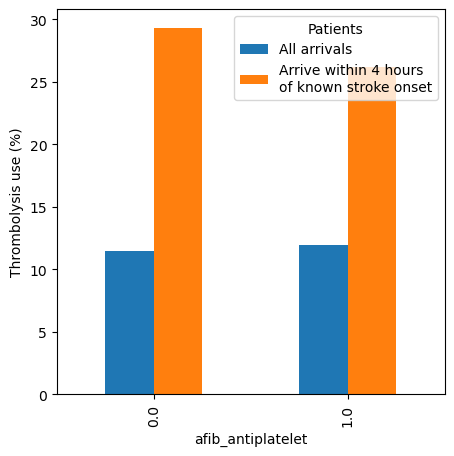

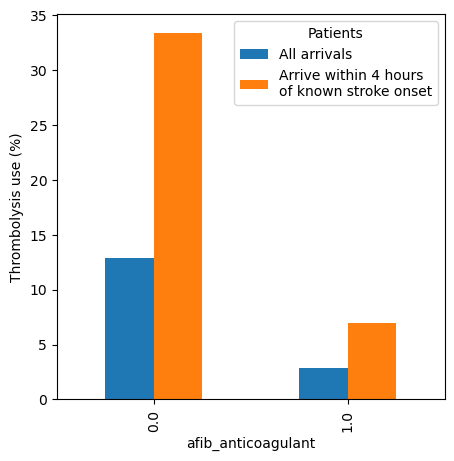

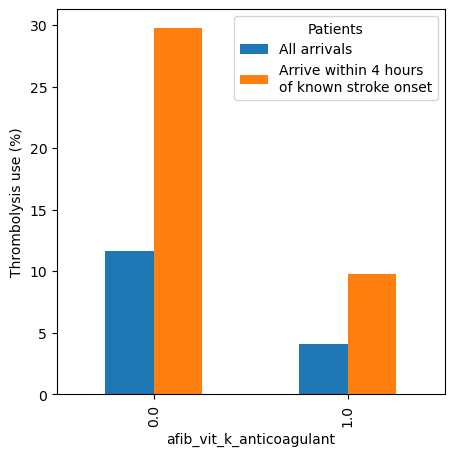

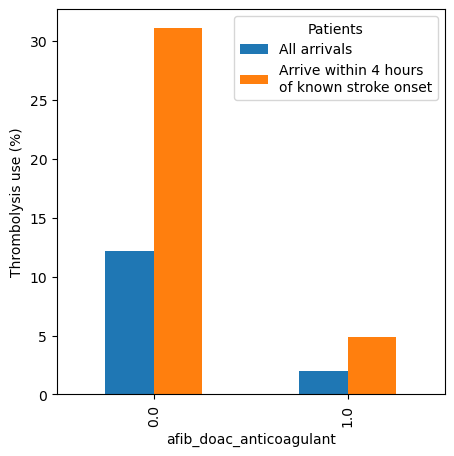

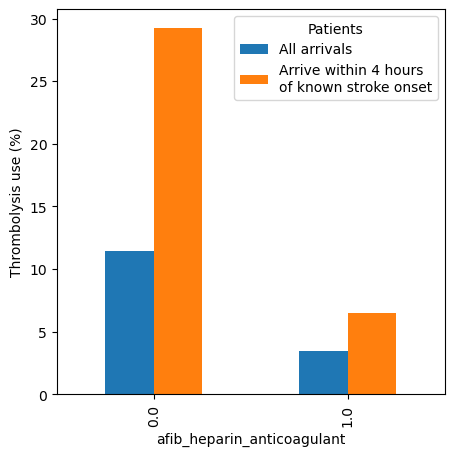

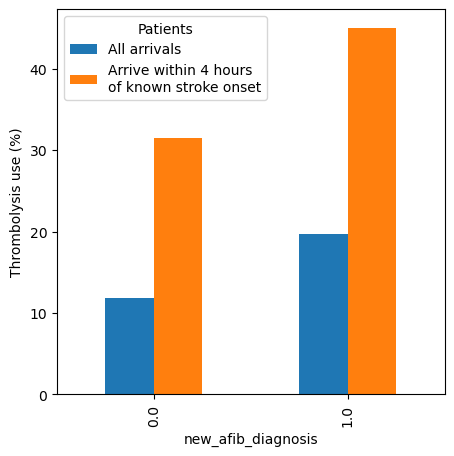

In [11]:
comords = ['congestive_heart_failure', 'hypertension', 'atrial_fibrillation',
           'diabetes', 'prior_stroke_tia', 'afib_antiplatelet',
           'afib_anticoagulant', 'afib_vit_k_anticoagulant',
           'afib_doac_anticoagulant', 'afib_heparin_anticoagulant',
           'new_afib_diagnosis']

for com in comords:
    plot_ivt_differences('bar', com, com)

## Reasons for not giving thrombolysis

May be more than one selected for each patient.

Just examining reasons for patients who arrived within 4 hours of known stroke onset.

In [12]:
# Restrict to patients who were not thrombolysed
not_ivt = data[data['thrombolysis'] == 0]

# Make list of "thrombolysis_no_but" columns
no_but_col = [col for col in data if (col.startswith('thrombolysis_no_but'))]

# Make list of "thrombolysis_no" columns
no_col = [col for col in not_ivt if (
    col.startswith('thrombolysis_no') &
    ~col.startswith('thrombolysis_no_but'))]

# Check that all patients have at least one reason provided
(not_ivt[no_col + no_but_col] == 1).any(axis=1).value_counts()

True    96964
dtype: int64

In [13]:
def plot_no_thrombolysis(df):
    # Find proportion of individuals with each answer
    reasons = df.mean().sort_values()*100

    # Plot results
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.barh(reasons.index, reasons)
    plt.title('Sample: Patients who were not thrombolysed, ' +
              'arrived within 4h known onset,\nand are ' +
              'recorded with one of the following reasons')
    ax.set_xlabel('Percentage of patients with this reason (%)')
    ax.grid(axis='x')
    plt.show()

'Total patients: 96480'

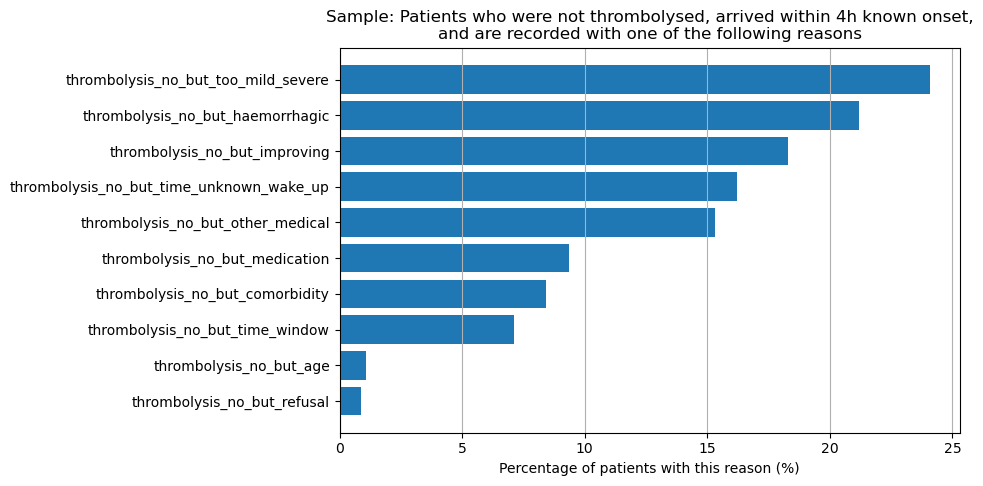

In [14]:
# Filter to patients who have "no but" reason
no_but_df = not_ivt.loc[(not_ivt[no_but_col] == 1).any(axis=1), no_but_col]
display(f'Total patients: {no_but_df.shape[0]}')

# Plot proportion with each answer
plot_no_thrombolysis(no_but_df)

Observations: Stroke being too mild or severe, and haemorrhagic stroke, are the most common reasons why thrombolysis was not given.

'Total patients: 484'

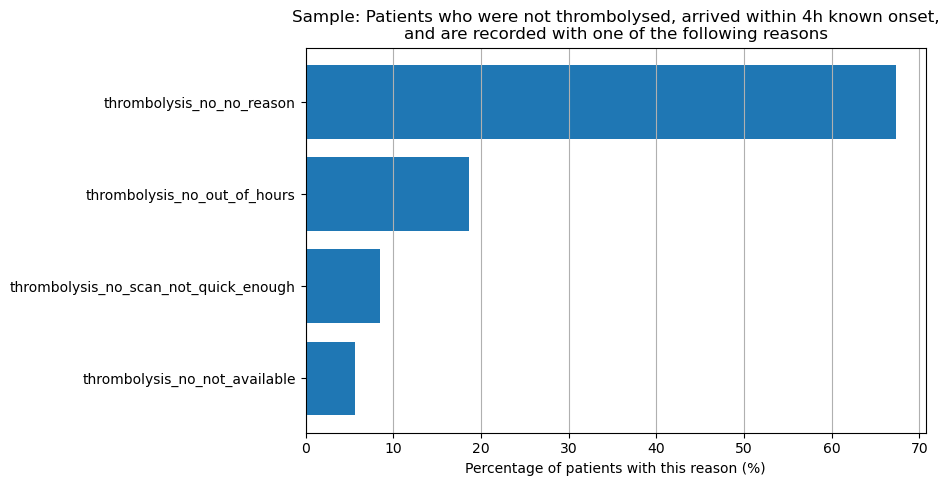

In [15]:
# Filter to patients who have "no but" reason
no_df = not_ivt.loc[(not_ivt[no_col] == 1).any(axis=1), no_col]
display(f'Total patients: {no_df.shape[0]}')

# Plot proportion with each answer
plot_no_thrombolysis(no_df)

Observations: Only a small number of patients are "thrombolysis no" (rather than "no but"). Here, the most common reason is no reason.

**Further analysis of "no but" - frequency of multiple reasons**

In [16]:
# Find the number of answers given per patients
multiple = (no_but_df
            .sum(axis=1)
            .value_counts()
            .to_frame('count')
            .reset_index(names='item'))

# Convert count to proportion
multiple['proportion'] = multiple['count'] / multiple['count'].sum()

display(multiple)

,item,count,proportion
0,1,78055,0.809028
1,2,15894,0.164739
2,3,2302,0.023860
3,4,208,0.002156
4,5,20,0.000207
5,6,1,0.000010


Observations: The majority of patients have one answer given (81%). Approximately 16% have 2 answers, 2% have 3 answers, and very few have more than 3.

In [17]:
multiple_df = no_but_df[no_but_df.sum(axis=1) > 1]
multiple_df.value_counts().reset_index(name='count').head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
thrombolysis_no_but_haemorrhagic,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
thrombolysis_no_but_time_window,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
thrombolysis_no_but_comorbidity,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,1
thrombolysis_no_but_medication,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,1,0,0,0
thrombolysis_no_but_refusal,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
thrombolysis_no_but_age,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
thrombolysis_no_but_improving,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,1,1,0
thrombolysis_no_but_too_mild_severe,1,1,0,0,1,0,0,0,1,1,1,0,0,0,1,0,0,0,1,0
thrombolysis_no_but_time_unknown_wake_up,0,1,0,1,0,0,1,0,0,0,0,0,1,1,1,1,0,0,0,0
thrombolysis_no_but_other_medical,0,0,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0


Observations: The top 5 move common combinations - 
1. "Stroke too mild or too severe" and "symptoms improving"
2. "Stroke too mild or too severe" and "symptom onset time unknown/wake-up stroke"
3. "Co-morbidity" and "Other medical reason"
4. "Arrived outside thrombolysis time window" and "symptom onset time unknown/wake-up stroke"
5. "Stroke too mild or too severe" and "Other medical reason"